# Library

In [1]:
import os
import gc
import random
import platform
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import supervised


In [2]:
print('Python version:', platform.python_version())
print('Numpy version:', np.__version__)
print('Pandas version:', pd.__version__)
print('Matplotlib version:', matplotlib.__version__)
print('Seaborn version:', sns.__version__)
print('mljar-supervised version:', supervised.__version__)


Python version: 3.8.5
Numpy version: 1.19.0
Pandas version: 1.0.5
Matplotlib version: 3.2.2
Seaborn version: 0.10.1
mljar-supervised version: 0.6.0


In [3]:
SEED = 42

os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)


# Dataset

In [4]:
df_train = pd.read_parquet('./data/processed/train_processed.parquet')
df_test = pd.read_parquet('./data/processed/test_processed.parquet')


# Preprocessing

In [5]:
df_train['day'] = pd.to_datetime(df_train['grass_date']).dt.dayofweek.astype('category').cat.codes
df_test['day'] = pd.to_datetime(df_test['grass_date']).dt.dayofweek.astype('category').cat.codes

del df_train['grass_date']
del df_test['grass_date']


In [6]:
def fix_age(age):
    if age < 18 or age >= 100:
        return np.nan
    else:
        return age
    
df_train['age'] = df_train['age'].apply(fix_age)
df_test['age'] = df_test['age'].apply(fix_age)


In [7]:
# last_open_day
df_train['last_open_day_nan'] = df_train['last_open_day'].isnull()
df_train['last_open_day'] = df_train['last_open_day'].fillna(-9999)

df_test['last_open_day_nan'] = df_test['last_open_day'].isnull()
df_test['last_open_day'] = df_test['last_open_day'].fillna(-9999)

# last_login_day
df_train['last_login_day_nan'] = df_train['last_login_day'].isnull()
df_train['last_login_day'] = df_train['last_login_day'].fillna(-9999)

df_test['last_login_day_nan'] = df_test['last_login_day'].isnull()
df_test['last_login_day'] = df_test['last_login_day'].fillna(-9999)

# last_checkout_day
df_train['last_checkout_day_nan'] = df_train['last_checkout_day'].isnull()
df_train['last_checkout_day'] = df_train['last_checkout_day'].fillna(-9999)

df_test['last_checkout_day_nan'] = df_test['last_checkout_day'].isnull()
df_test['last_checkout_day'] = df_test['last_checkout_day'].fillna(-9999)

# attr_1
df_train['attr_1_nan'] = df_train['attr_1'].isnull()
df_train['attr_1'] = df_train['attr_1'].fillna(-9999)

df_test['attr_1_nan'] = df_test['attr_1'].isnull()
df_test['attr_1'] = df_test['attr_1'].fillna(-9999)

# attr_2
df_train['attr_2_nan'] = df_train['attr_2'].isnull()
df_train['attr_2'] = df_train['attr_2'].fillna(-9999)

df_test['attr_2_nan'] = df_test['attr_2'].isnull()
df_test['attr_2'] = df_test['attr_2'].fillna(-9999)

# attr_3
df_train['attr_3_nan'] = df_train['attr_3'].isnull()
df_train['attr_3'] = df_train['attr_3'].fillna(-9999)

df_test['attr_3_nan'] = df_test['attr_3'].isnull()
df_test['attr_3'] = df_test['attr_3'].fillna(-9999)

# age
df_train['age_nan'] = df_train['age'].isnull()
df_train['age'] = df_train['age'].fillna(-9999)

df_test['age_nan'] = df_test['age'].isnull()
df_test['age'] = df_test['age'].fillna(-9999)

# domain
# 1 -> 'other' domain from previous preprocessing
df_train['domain_nan'] = df_train['domain'].isnull()
df_train['domain'] = df_train['domain'].fillna(1)

df_test['domain_nan'] = df_test['domain'].isnull()
df_test['domain'] = df_test['domain'].fillna(1)


In [8]:
X_train = df_train.copy()
del X_train['open_flag']

X_test = df_test.copy()

y_train = df_train['open_flag'].to_numpy()


In [9]:
cat_feature = [
    'country_code','attr_1', 'attr_2', 'attr_3',
    'domain', 'last_open_day_nan', 'last_login_day_nan',
    'last_checkout_day_nan', 'attr_1_nan', 'attr_2_nan',
    'attr_3_nan', 'age_nan', 'domain_nan', 'day'
]
cat_feature_idx = [X_train.columns.get_loc(ct) for ct in cat_feature]
cat_feature_idx


[0, 14, 15, 16, 18, 20, 21, 22, 23, 24, 25, 26, 27, 19]

# Model functions

In [10]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix, matthews_corrcoef

def predict(model, X, tweak_proba=False):
    y = model.predict(X)
    if tweak_proba:
        for i in y.index:
            # y.loc[i, 'prediction_0'] = y.loc[i, 'prediction_0'] * 1.0
            y.loc[i, 'prediction_1'] = y.loc[i, 'prediction_1'] * 1.1
            if y.loc[i, 'prediction_1'] > y.loc[i, 'prediction_0']:
                y.loc[i, 'label'] = 1
            else:
                y.loc[i, 'label'] = 0
    y = y['label'].to_numpy()
    return y

def metrics(y_true, y_pred):
    print('Weighted F1 Score :', f1_score(y_true, y_pred, average='weighted'))
    print('MCC Score :', matthews_corrcoef(y_true, y_pred))
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    cm = pd.DataFrame(cm, [0, 1], [0, 1])

    sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt="d")
    plt.show()


# mljar-supervised

In [11]:
automl = supervised.automl.AutoML(
    mode="Compete",
    ml_task='binary_classification',
    total_time_limit=60 * 60, # None cause bug at end of fit, use very huge number instead
    # skip nearest neighbor due to bad performance
    # skip neural network due to long training time
    golden_features=False,
    # feature_selection=True,
    seed=SEED,
)
automl.fit(X_train, y_train)


Create directory AutoML_5
AutoML task to be solved: binary_classification
AutoML will use algorithms: ['Linear', 'Decision Tree', 'Random Forest', 'Extra Trees', 'LightGBM', 'Xgboost', 'CatBoost', 'Neural Network', 'Nearest Neighbors']
AutoML will optimize for metric: logloss
1_DecisionTree final logloss 0.30222759089763096 time 4.26 seconds
2_DecisionTree final logloss 0.3237892272457907 time 3.38 seconds
3_DecisionTree final logloss 0.3242503270791042 time 3.29 seconds
4_Linear final logloss 0.3102813128935084 time 24.35 seconds
5_Default_RandomForest final logloss 0.2909245101979197 time 43.78 seconds
6_Default_ExtraTrees final logloss 0.3015938006325861 time 43.1 seconds
7_Default_Xgboost final logloss 0.27870790809747814 time 28.87 seconds
8_Default_LightGBM final logloss 0.2785467404770703 time 12.7 seconds
9_Default_CatBoost final logloss 0.278576976805828 time 89.42 seconds
10_Default_NeuralNetwork final logloss 0.2957756579817042 time 3246.51 seconds
The file with features to 

Weighted F1 Score : 0.8890371585594741
MCC Score : 0.5853329969239374
              precision    recall  f1-score   support

           0       0.94      0.93      0.93     62083
           1       0.63      0.68      0.65     11456

    accuracy                           0.89     73539
   macro avg       0.78      0.80      0.79     73539
weighted avg       0.89      0.89      0.89     73539



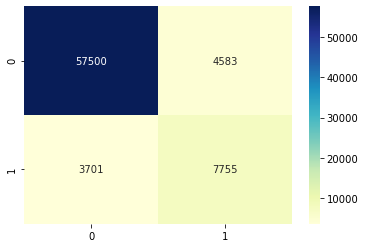

In [12]:
y_train_pred = predict(automl, X_train)
metrics(y_train, y_train_pred)


Weighted F1 Score : 0.8921385849585508
MCC Score : 0.5778129183448579
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     62083
           1       0.77      0.52      0.62     11456

    accuracy                           0.90     73539
   macro avg       0.84      0.74      0.78     73539
weighted avg       0.89      0.90      0.89     73539



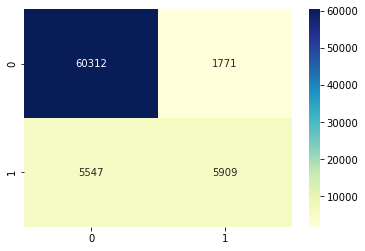

In [13]:
y_train_pred = predict(automl, X_train, tweak_proba=True)
metrics(y_train, y_train_pred)


In [14]:
y_test_pred = predict(automl, X_test)

df_submission = pd.concat([pd.Series(list(range(0, len(X_test))), name='row_id', dtype=np.int32), pd.Series(y_test_pred, name='open_flag')], axis=1)
df_submission.to_csv(f'./data/submission/submission_{datetime.now()}.csv', index=False)

df_submission



,row_id,open_flag
0,0,1
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
55965,55965,0
55966,55966,0
55967,55967,0
55968,55968,1
